<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# install necessary modules
!pip install yfinance
!pip install plotly
!pip install ta

In [35]:
import os, time
import yfinance as yf
import requests
import numpy as np
import math
import time
import json

from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt

from ta.trend import MACD
from ta.momentum import StochasticOscillator
from ta.momentum import RSIIndicator


from tabulate import tabulate

In [36]:
  INFO = 1
  DEBUG = 2
  TRACE = 3
  print_level = DEBUG 
  nr_of_features = 1
  look_forward = 1
  epochs = 120
  learning_rate=0.0042
  np.random.seed(42)
  look_back = 14 #  number of past days we want to use to predict 1 day in the future.
  split_percent = 0.90 # use 90% of the data  for train

  if look_back < 5:
    num_prediction = look_back * 4
  else:
    num_prediction = look_back * 2


In [37]:
def get_stock_price(ticker, from_date):
  df = yf.download(ticker.ticker, start=from_date, interval="1d")
  #df = df.rename(columns={"Close": "Close1", "Adj Close": "Close"})
  
  #ticker = yf.Ticker(symbol)

  #df = ticker.history(start=from_date, interval="1d")
  #print(df.info())
  df['Date'] = pd.to_datetime(df.index)
  #df['Date'] = df['Date'].apply(mpl_dates.date2num)
  #df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  df['EMA21'] = df['Close'].ewm(span=21, adjust=False).mean()
  df['MA20'] =  df['Close'].rolling(window=20).mean()
  df['MA50'] = df['Close'].rolling(window=50).mean()
  df['MA100'] = df['Close'].rolling(window=100).mean()
  df['MA200'] = df['Close'].rolling(window=200).mean()
  df['MA300'] = df['Close'].rolling(window=200).mean()
  print('Get Stock Price', ticker.ticker, 'done.')
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for level in levels]) == 0

def findNearestGreaterThan(searchVal, inputData):
    diff = inputData - searchVal
    diff[diff<0] = np.inf
    idx = diff.argmin()
    return inputData[idx]


def findNearestLessThan(searchVal, inputData):
    diff = inputData - searchVal
    diff[diff>0] = -np.inf
    idx = diff.argmax()
    return inputData[idx]

def indicators(chart_df):
  # MACD
  macd = MACD(close=chart_df['Close'], 
            window_slow=26,
            window_fast=12, 
            window_sign=9)
  # stochastics
  stoch = StochasticOscillator(high=chart_df['High'],
                             close=chart_df['Close'],
                             low=chart_df['Low'],
                             window=14, 
                             smooth_window=3)

  rsi = RSIIndicator(close=chart_df['Close'], window=14)
  return macd, stoch, rsi

In [38]:
def calculate_levels(chart_df,close_price):
  levels = []
  low = 0
  high = np.round(chart_df['Close'].max(),1)
  for i in range(2,len(chart_df)-2):
    try:
      if is_support(chart_df,i):
        low = chart_df['Low'][i]
      if is_far_from_level(low, levels, chart_df):
        levels.append(low)
      elif is_resistance(chart_df,i):
        high = chart_df['High'][i]
      if is_far_from_level(high, levels, chart_df):
        levels.append(high)
    except:
      print('calculate_levels error')
  levels = sorted(levels, reverse=True)

  min_level = np.round(findNearestLessThan(close_price,levels),1)
  if(min_level > close_price):
    min_level = np.round(close_price * 0.8,1)

  max_level = np.round(findNearestGreaterThan(close_price,levels),1)
  if(max_level < close_price):
    max_level = np.round(close_price * 1.2,1)

#  print('close_price',close_price,'min_level:',min_level,'max_level:', max_level)
  return levels, min_level, max_level

In [39]:
def options_chain(ticker):

    #tk = yf.Ticker(symbol)
    # Expiration dates
    exps = ticker.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = ticker.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate'])
    options.insert(0,'dte',(options['expirationDate'] - datetime.today()).dt.days + 1)
    options['expirationDate'] = options['expirationDate'].dt.date
    # Boolean column if the option is a CALL x : True if (x > 10 and x < 20) else False
    options.insert(1,'CALL',options['contractSymbol'].str[4:].apply(lambda x: "C" in x))
    
    options[['bid', 
             'ask', 
             'strike', 
             'lastPrice', 
             'volume',
             'change',
             'percentChange',
             'openInterest',
             'impliedVolatility']] = options[[
                                   'bid', 
                                   'ask', 
                                   'strike',
                                   'lastPrice',
                                   'volume',
                                   'change',
                                   'percentChange',
                                   'openInterest',
                                   'impliedVolatility']].apply(pd.to_numeric)
    
    options['spread%'] = np.round(100 - ((options['bid'] / options['ask']) * 100),1) # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    #options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
    print('Get options',ticker.ticker,'done.')
    return options

In [52]:
def find_level_optionInterests(options_df,ticker,close_price,min_level,max_level, dte_min, dte_max):
  options_df['impliedVolatility'] = np.round(options_df['impliedVolatility'],2)
  options_df['percentChange'] = np.round(options_df['percentChange'],2)
  #expirationDates = options_df['expirationDate'].unique()
  #print(sorted(expirationDates))

  #PUT_options_df = pd.DataFrame()
  #CALL_options_df = pd.DataFrame()

  #for key, value in options_df.items():
  #  date = key
  #  rsi = float(value.get('RSI'))
  #  rsi_data.append([date,rsi])
#  print('PUT OPTIONS', 'CLOSE PRICE:',close_price, 'SUPPORT -15%:', np.round(min_level * 0.85,2), 'RESISTANCE +15%:', np.round(max_level * 1.15,2))
  PUT_options_df = options_df.query('CALL == False and strike>' + str(min_level * 0.85) + ' and strike<' + str(max_level * 1.15) + ' and dte>' + str(dte_min) + ' and dte<' + str(dte_max))
  put_max_openInterest_index = PUT_options_df["openInterest"].idxmax()
  put_max_volume_index = PUT_options_df["volume"].idxmax()
  PUT_options_to_return_df = PUT_options_df.loc[put_max_openInterest_index:put_max_openInterest_index]
  PUT_options_to_return_df = PUT_options_to_return_df.append(PUT_options_df.loc[put_max_volume_index:put_max_volume_index])
  PUT_options_to_return_df = PUT_options_to_return_df.drop(columns = ['contractSize', 'currency','change','percentChange', 'lastTradeDate', 'lastPrice', 'inTheMoney','contractSymbol']) 
  
#  print(tabulate(PUT_options_to_return_df, headers = 'keys', tablefmt = 'psql'))

#  print('CALL OPTIONS', 'CLOSE PRICE:',close_price, 'SUPPORT -15%:', np.round(min_level * 0.85,2), 'RESISTANCE +15%:', np.round(max_level * 1.15,2))
  CALL_options_df = options_df.query('CALL == True and strike>' + str(min_level * 0.85) + ' and strike<' + str(max_level * 1.15) + ' and dte>' + str(dte_min) + ' and dte<' + str(dte_max))
  call_max_openInterest_index = CALL_options_df["openInterest"].idxmax()
  call_max_volume_index = CALL_options_df["volume"].idxmax()
  CALL_options_to_return_df = CALL_options_df.loc[call_max_openInterest_index:call_max_openInterest_index]
  CALL_options_to_return_df = CALL_options_to_return_df.append(CALL_options_df.loc[call_max_volume_index:call_max_volume_index])
  CALL_options_to_return_df = CALL_options_to_return_df.drop(columns = ['contractSize', 'currency', 'change','percentChange', 'lastTradeDate', 'lastPrice', 'inTheMoney','contractSymbol']) 
#  print(call_max_openInterest_index,tabulate(CALL_options_to_return_df, headers = 'keys', tablefmt = 'psql'))
  return PUT_options_to_return_df, CALL_options_to_return_df

In [41]:
def predict(indicators_lstm_test_data_scaled, model):
    prediction_list = indicators_lstm_test_data_scaled[-look_back:]
    #print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

In [42]:
def get_prediction_data(df,ticker):

  indicators_model_file_path = '/content/drive/MyDrive/models/' + ticker.ticker + '_' + str(look_back) + '_' + str(nr_of_features) + '_indicators_10.h5'
  
  indicators_model = None
  try:
    indicators_model = keras.models.load_model(indicators_model_file_path)
    #modified = os.path.getmtime(indicators_model_file_path)

    #print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
    #print('Loaded', indicators_model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
  except:
    indicators_model = None
    print('Model ' + indicators_model_file_path + ' does not exists.')

  indicators_lstm_data = np.expand_dims(df['RSI'].values.copy()[look_back:], axis=1).astype(float)
  split = int(split_percent*len(indicators_lstm_data))
 
  indicators_scaler = MinMaxScaler(feature_range=(0, 1))
  indicators_scaler = indicators_scaler.fit(indicators_lstm_data)

  indicators_lstm_train_data = indicators_lstm_data[:split]
  indicators_lstm_test_data = indicators_lstm_data[split:]
  
  indicators_lstm_train_data_scaled = indicators_scaler.transform(indicators_lstm_train_data)
#  print(indicators_lstm_train_data_scaled[:look_back*2])
#  print(indicators_lstm_train_data_scaled.shape)
  
  indicators_lstm_test_data_scaled = indicators_scaler.transform(indicators_lstm_test_data)
#  print(indicators_lstm_test_data_scaled[:look_back+1])
#  print(indicators_lstm_test_data_scaled.shape)

  indicators_train_generator = TimeseriesGenerator(indicators_lstm_train_data_scaled, indicators_lstm_train_data_scaled, sampling_rate=1, length=look_back, batch_size=64)

  if indicators_model is None:
    indicators_model = Sequential()
    indicators_model.add(LSTM(units=42, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, activation="tanh"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(Dense(nr_of_features))

    indicators_model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=['mae','mse']
    )
    
    #indicators_model.summary()
    print('Model ' + indicators_model_file_path + ' compiled.')

    indicators_modelo = indicators_model.fit(indicators_train_generator, epochs=epochs, verbose=0 )
  
    indicators_model.save(indicators_model_file_path)
    print('Saved model ' + indicators_model_file_path)

  
    plt.plot(indicators_modelo.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

  indicators_test_generator = TimeseriesGenerator(indicators_lstm_test_data_scaled, indicators_lstm_test_data_scaled,sampling_rate=1, length=look_back, batch_size=look_back)
  #Make test prediction
  indicators_test_prediction_scaled = indicators_model.predict(indicators_test_generator)
  indicators_test_prediction = indicators_scaler.inverse_transform(indicators_test_prediction_scaled)
  indicators_test_prediction = indicators_test_prediction.reshape((-1))

  #Make future prediction
  indicators_prediction_scaled = predict(indicators_lstm_test_data_scaled, indicators_model)
  indicators_prediction = indicators_scaler.inverse_transform(indicators_prediction_scaled.reshape((-1,nr_of_features)))
  indicators_prediction = indicators_prediction.reshape((-1))
  print('Get prediction data',ticker.ticker,'done.')
  return indicators_test_prediction, indicators_prediction

In [50]:
def get_news(ticker):
  news_data = []
  for headline in ticker.news:
    providerPublishTime = datetime.fromtimestamp((headline['providerPublishTime'])).strftime('%Y-%m-%d %H:%M:%S')
    link = '<a href="'+ headline['link']+'">' + headline['title'] + '</a>'
    publisher = headline['publisher'] 
    news_data.append([providerPublishTime,publisher,link])
  news_df = pd.DataFrame(news_data, columns=['Time','Publisher', 'Title'])
  print('Get news',ticker.ticker,'done.')  
  return news_df

In [44]:
def get_earning(ticker):
  earning_date = None
  if ticker.calendar is not None:
    try:
      print(ticker.calendar.iloc[0])
      earning_date = ticker.calendar.iloc[0][0]
      print('Get calendar',ticker.ticker,'done.')
    except:
      print('Get calendar',ticker.ticker,'error.')
  return earning_date

In [54]:
def get_chart(ticker, df, indicators_test_prediction, indicators_prediction):
  days = 365
  last_day_df = df[-1:]
  last_date = last_day_df['Date'].index[0].date()
  close_price = np.round(last_day_df['Close'][0],1)

  ath = np.round(df['Close'].max(),1)
  discount = np.round(ath - close_price,1)
  discount_percent = np.round((discount / close_price) * 100, 1)
  
  chart_df = df.tail(days)

  levels, min_level, max_level = calculate_levels(chart_df,close_price)

  min_level_0_85 = np.round(min_level * 0.85,2)
  min_level_0_85_discount = np.round(min_level_0_85 - close_price)
  min_level_0_85_discount_percent =  np.round((min_level_0_85_discount / close_price) * 100, 1)

  max_level_1_15 = np.round(max_level * 1.15,2)
  max_level_1_15_discount = np.round(max_level_1_15 - close_price)
  max_level_1_15_discount_percent = np.round((max_level_1_15_discount / close_price) * 100, 1)

  options_df = pd.DataFrame()
  all_options_df = options_chain(ticker)
  near_PUT_options_df, near_CALL_options_df = find_level_optionInterests(all_options_df,ticker,close_price,min_level_0_85,max_level_1_15, -1, 33)
  far_PUT_options_df, far_CALL_options_df = find_level_optionInterests(all_options_df,ticker,close_price,min_level_0_85,max_level_1_15, 33, 333)

  options_df = options_df.append(near_PUT_options_df)
  options_df = options_df.append(far_PUT_options_df)
  options_df = options_df.append(near_CALL_options_df)
  options_df = options_df.append(far_CALL_options_df)
  options_df.insert(3,'Price',close_price)
  options_df = options_df.sort_values(by=['dte'])

  min_level_discount = np.round(min_level - close_price)
  min_level_discount_percent = np.round((min_level_discount / close_price) * 100, 1)
  
  max_level_discount = np.round(max_level - close_price)
  max_level_discount_percent = np.round((max_level_discount / close_price) * 100, 1)
  
  tradingview_link = '<a href="https://in.tradingview.com/chart/66XmQfYy/?symbol=' + ticker.ticker +'">' +  ticker.ticker + ' ' + str(last_date)  +'</a> '
  seeking_alpha_link = '<a href="https://seekingalpha.com/symbol/'+ ticker.ticker +'"> Seeking Alpha </a> '
  google_news_link = '<a href="https://news.google.com/search?for=' + ticker.ticker + '+stock when:7d&hl=en-US&gl=US&ceid=US%3Aen"> Google News </a> '
#  twitter_link = '<a href="https://twitter.com/search?q=$' + ticker.ticker + '%20stock&src=typed_query&f=live"> Twitter </a> '

  title = '<b>' + tradingview_link + '</b> ' + seeking_alpha_link + google_news_link + 'Earning:' + str(get_earning(ticker))
  title += '<br>'
  title += '<b>Close Price:</b>' + str(close_price) + ' <b>ATH:</b>' + str(ath) + ' <b>Discount:</b>' + str(discount) + ' (' + str(discount_percent) + '%)'
  title += '<br>'
  title += '<b>Support:</b>' + str(min_level) + ' ('+str(min_level_discount_percent)+'%) ' 
  title += '<b>Close Price:</b>' + str(close_price) + ' ' 
  title += '<b>Resistance:</b>' + str(max_level) + ' ('+str(max_level_discount_percent)+'%) '
  title += '<br>' 
  title += '<b>Support -15%:</b>' + str(min_level_0_85) + ' (' + str(min_level_0_85_discount_percent) + '%) '
  title += '<b>Close Price:</b>' + str(close_price) + ' ' 
  title += '<b>Resistance +15%:</b>' + str(max_level_1_15) + ' (' + str(max_level_1_15_discount_percent) +  '%) '
  
  # add subplot properties when initiliazing fig variable
  fig = make_subplots(rows=6, cols=1, shared_xaxes=True,
                    vertical_spacing=0.012, 
                    row_heights=[0.30,0.05,0.10,0.158,0.10,0.27],
                    subplot_titles=[title],
                    specs=[
                           [{"type": "candlestick"}],
                           [{"type": "bar"}],
                           [{"type": "scatter"}],
                           [{"type": "table"}],
                           [{"type": "scatter"}],
                           [{"type": "table"}]
                           ])

  candlestick_row = 1
  volume_row = 2
  table_row = 4
  rsi_row = 3
  macd_row = 5
  news_row = 6
  

  fig.update_layout(
      height=1400, width=1200, 
      showlegend=True,
      dragmode= 'pan',
      margin=go.layout.Margin(
          l=20, #left margin
          r=20, #right margin
          b=20, #bottom margin
          t=100  #top margin
      ))

  fig.update_annotations({'font': {'size': 12}}) 

  # Options Table 
  fig.add_trace(
      go.Table(
        header=dict(values=list(options_df.columns),
                fill_color='paleturquoise',
                font=dict(color='black', size=12),
                align='left'),
        cells=dict(values=options_df.transpose().values.tolist(),
               fill_color='lavender',
               align='left')
        ),row=table_row, col=1)

  # News table
  news_df = get_news(ticker)
  fig.add_trace(
    go.Table(
          columnwidth = [80,80,400],  
          header=dict(values=list(news_df.columns),
                fill_color='paleturquoise',
                align='left'),
          cells=dict(values=[news_df.Time, news_df.Publisher, news_df.Title],
               fill_color='lavender',
               align='left')
      ),
    row=news_row, 
    col=1)


  # Plot RSI trace 
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['RSI'],
                          line=dict(color='royalblue', width=2),
                          name='RSI(14)'
                          ), row=rsi_row, col=1)
  if indicators_test_prediction is not None and indicators_prediction is not None:
    fig.add_trace(go.Scatter(x=chart_df['Date'].tail(len(indicators_test_prediction)),
                          y = indicators_test_prediction,
                          line=dict(color='firebrick', width=3, dash = 'dash'),
                          name='RSI(14) Test Predict'
                          ), row=rsi_row, col=1)
  
    indicators_prediction_dates = predict_dates(last_date)
    fig.add_trace(go.Scatter(x=indicators_prediction_dates,
                          y = indicators_prediction,
                          line=dict(color='firebrick', width=3, dash = 'dot'),
                          name='RSI(14) Future Predict'
                          ), row=rsi_row, col=1)
 

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [70, 70],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash'),
          name = 'RSI(14) over bought'
      ),row=rsi_row, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [50, 50],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash'),
          name='RSI(14) Neutral'
      ),row=rsi_row, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [30, 30],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash'),
          name='RSI(14) over sold'
      ),row=rsi_row, col=1)


  # Plot OHLC on 3st subplot (using the codes from before)
  fig.add_trace(go.Candlestick(x=chart_df.index,
                             open=chart_df['Open'],
                             high=chart_df['High'],
                             low=chart_df['Low'],
                             close=chart_df['Close'], 
                             name=ticker.ticker,
                             showlegend=True), row=candlestick_row, col=1)
  

  # add moving average traces
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA20'], 
                         line=dict(color='lightgreen', width=2), 
                         name='MA 20'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['EMA21'], 
                         line=dict(color='green', width=2), 
                         name='EMA 21'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA50'], 
                         line=dict(color='blue', width=2), 
                         name='MA 50'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA100'], 
                         line=dict(color='orange', width=2), 
                         name='MA 100'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA200'], 
                         line=dict(color='red', width=2), 
                         name='MA 200'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA300'], 
                         line=dict(color='black', width=2), 
                         name='MA 300'), row=candlestick_row, col=1)


  start_date = "2021-06-01"
  end_date = "2022-01-31"
  #zoom_df = chart_df.iloc['Date' >= start_date]
  
  zoom_df = chart_df[chart_df.Date >= start_date]
  y_zoom_max = zoom_df["High"].max()
  y_zoom_min = zoom_df["Low"].min()

  ath_percent = 0
  
  for idx, level in  enumerate(levels):
      percent = 0
      if idx == 0:
        ath = level
      current_level = level
      if idx > 0:
        prev_level = levels[idx-1]
        diff = prev_level - current_level
        ath_diff = ath - current_level
        percent = (diff / current_level) * 100
        ath_percent =  (ath_diff / current_level) * 100
      if level <= (min_level * 0.85) or level >= (max_level * 1.15):
        line_color = 'rgba(100, 10, 100, 0.2)'
      else:
        line_color = 'rgba(200, 20, 200, 1)'
      fig.add_trace(go.Scatter(
          x = [chart_df.index.min(), chart_df.index.max()],
          y = [level, level],
          mode="lines+text",
          name="Lines and Text",
          showlegend=False,
          text=['','$' + str(np.round(current_level,1)) + ' (' + str(np.round(percent,1)) + '% disc:' + str(np.round(ath_percent,1))+ '%)',''],
          textposition="top right",
          line = dict(shape = 'linear', color = line_color, dash = 'dash', width=1)
        ), row=candlestick_row, col=1)


  # Plot volume trace on 4d row 
  colors = ['green' if row['Open'] - row['Close'] >= 0 
            else 'red' for index, row in chart_df.iterrows()]
  fig.add_trace(go.Bar(x=chart_df.index, 
                      y=chart_df['Volume'],
                      marker_color=colors,
                      name='Volume'
                      ), row=volume_row, col=1)


  # Plot MACD trace on 5rd row
  colors = ['green' if val >= 0 
            else '#FF5733' for val in macd.macd_diff()]
  fig.add_trace(go.Bar(x=chart_df.index, 
                      y=chart_df['MACD_DIFF'],
                      marker_color=colors,
                      name='MACD diff'
                      ), row=macd_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['MACD'],
                          line=dict(color='green', width=2),
                          name='MACD'
                          ), row=macd_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['MACD_SIGNAL'],
                          line=dict(color='red', width=1),
                          name='MACD signal'
                          ), row=macd_row, col=1)

  fig.update_layout(xaxis_rangeslider_visible=False)
  fig.update_xaxes(type="date", range=[start_date, end_date])
  fig.update_yaxes(range=[y_zoom_min,y_zoom_max], row=candlestick_row, col=1)
  fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
  fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')

  folder='/content/drive/MyDrive/models/charts/'+ str(last_date)
  Path(folder).mkdir(parents=True, exist_ok=True)
  chartPath = folder + '/' + ticker.ticker + '.html'
  print('Chart saved:', chartPath)
  fig.write_html(chartPath)
  print('Get chart',ticker.ticker,'done.') 
  return fig

In [55]:
ticker = yf.Ticker('U')
df = get_stock_price(ticker,"2019-01-01")

#print(ticker.recommendations)
#print(ticker.calendar)
#print(get_earning(ticker))

macd, soch, rsi = indicators(df)
df['RSI'] = rsi.rsi().to_numpy()
df['MACD_DIFF'] = macd.macd_diff().to_numpy()
df['MACD'] = macd.macd().to_numpy()
df['MACD_SIGNAL'] = macd.macd_signal().to_numpy()

indicators_test_prediction, indicators_prediction = get_prediction_data(df,ticker)
#print(prediction_data)
#print(forecast_data)
#fig = get_chart(ticker, df, None, None)
fig = get_chart(ticker, df, indicators_test_prediction, indicators_prediction)
fig.show()

[*********************100%***********************]  1 of 1 completed
Get Stock Price U done.
Get prediction data U done.
Get options U done.
Value    2022-02-03 21:00:00
Name: Earnings Date, dtype: object
Get calendar U done.
Get news U done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/U.html
Get chart U done.


In [56]:
def save_charts(symbols, predict):
  error_log = []
  for symbol in symbols:    
    try:      
        ticker = yf.Ticker(symbol)
        df = get_stock_price(ticker,"2019-01-01")
        #print(list(df.columns))
        macd, soch, rsi = indicators(df)
        df['RSI'] = rsi.rsi().to_numpy()
        df['MACD_DIFF'] = macd.macd_diff().to_numpy()
        df['MACD'] = macd.macd().to_numpy()
        df['MACD_SIGNAL'] = macd.macd_signal().to_numpy()
        if predict is True:
          indicators_test_prediction, indicators_prediction = get_prediction_data(df,ticker)
          get_chart(ticker, df, indicators_test_prediction, indicators_prediction)
        else:
          get_chart(ticker, df, None, None)
    except:
      print('Error ticker:' + symbol)
      error_log.append(symbol)
  if len(error_log) > 0:
    print('Errors:', error_log)
  return None

[*********************100%***********************]  1 of 1 completed
Get Stock Price ABBV done.
Get prediction data ABBV done.
Get options ABBV done.
Get options ABBV done.
Value    2022-02-02 13:30:00
Name: Earnings Date, dtype: object
Get calendar ABBV done.
Get news ABBV error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/ABBV.html
Get chart ABBV done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price AFRM done.
Get prediction data AFRM done.
Get options AFRM done.
Get options AFRM done.
0    2022-02-09 00:00:00
1    2022-02-14 00:00:00
Name: Earnings Date, dtype: object
Get calendar AFRM done.
Get news AFRM done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/AFRM.html
Get chart AFRM done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price AMD done.
Get prediction data AMD done.
Get options AMD done.
Get options AMD done.
0    2022-01-24 00:00:00
1    2022-01-28 00:00:00
Name: Earnings Date, dtype: object
Get calendar AMD done.
Get news AMD error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/AMD.html
Get chart AMD done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price AMZN done.
Get prediction data AMZN done.
Get options AMZN done.
Get options AMZN done.
0    2022-01-31 00:00:00
1    2022-02-04 00:00:00
Name: Earnings Date, dtype: object
Get calendar AMZN done.
Get news AMZN done.
Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/AMZN.html
Get chart AMZN done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price APPS done.
Get prediction data APPS done.
Get options APPS done.
Get options APPS done.
0    2022-02-01 21:00:00
1    2022-02-07 21:00:00
Name: Earnings Date, dtype: object
Get calendar APPS done.
Get news APPS error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/APPS.html
Get chart APPS done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price ASTR done.
Get prediction data ASTR done.
Get options ASTR done.
Get options ASTR done.
Value    2021-11-11 00:00:00
Name: Earnings Date, dtype: object
Get calendar ASTR done.
Get news ASTR error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/ASTR.html
Get chart ASTR done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price ATVI done.
Get prediction data ATVI done.
Get options ATVI done.
Get options ATVI done.
0    2022-02-02 00:00:00
1    2022-02-07 00:00:00
Name: Earnings Date, dtype: object
Get calendar ATVI done.
Get news ATVI error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/ATVI.html
Get chart ATVI done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price BNGO done.
Get prediction data BNGO done.
Get options BNGO done.
Get options BNGO done.
Series([], Name: Earnings Date, dtype: float64)
Get calendar BNGO error.
Get news BNGO error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/BNGO.html
Get chart BNGO done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price CAT done.
Get prediction data CAT done.
Get options CAT done.
Get options CAT done.
0    2022-01-27 00:00:00
1    2022-01-31 00:00:00
Name: Earnings Date, dtype: object
Get calendar CAT done.
Get news CAT error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/CAT.html
Get chart CAT done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price CCL done.
Get prediction data CCL done.
Get options CCL done.
Get options CCL done.
0    2022-01-10 00:00:00
1    2022-01-14 00:00:00
Name: Earnings Date, dtype: object
Get calendar CCL done.
Get news CCL error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/CCL.html
Get chart CCL done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price CHWY done.
Get prediction data CHWY done.
Get options CHWY done.
Get options CHWY done.
0    2022-03-28 00:00:00
1    2022-04-01 00:00:00
Name: Earnings Date, dtype: object
Get calendar CHWY done.
Get news CHWY error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/CHWY.html
Get chart CHWY done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price COST done.
Get prediction data COST done.
Get options COST done.
Get options COST done.
Value    2022-03-03 16:15:00
Name: Earnings Date, dtype: object
Get calendar COST done.
Get news COST done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/COST.html
Get chart COST done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price CRM done.
Get prediction data CRM done.
Get options CRM done.
Get options CRM done.
0    2022-02-23 10:59:00
1    2022-02-28 12:00:00
Name: Earnings Date, dtype: object
Get calendar CRM done.
Get news CRM error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/CRM.html
Get chart CRM done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price DIA done.
Get prediction data DIA done.
Get options DIA done.
Get options DIA done.
Get news DIA done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/DIA.html
Get chart DIA done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price DIS done.
Get prediction data DIS done.
Get options DIS done.
Get options DIS done.
Value    2022-02-09 21:00:00
Name: Earnings Date, dtype: object
Get calendar DIS done.
Get news DIS done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/DIS.html
Get chart DIS done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price DKNG done.
Get prediction data DKNG done.
Get options DKNG done.
Get options DKNG done.
0    2022-02-24 13:30:00
1    2022-02-28 13:30:00
Name: Earnings Date, dtype: object
Get calendar DKNG done.
Get news DKNG error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/DKNG.html
Get chart DKNG done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price ETSY done.
Get prediction data ETSY done.
Get options ETSY done.
Get options ETSY done.
0    2022-02-23 00:00:00
1    2022-02-28 00:00:00
Name: Earnings Date, dtype: object
Get calendar ETSY done.
Get news ETSY error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/ETSY.html
Get chart ETSY done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price FFND done.
Error ticker:FFND
[*********************100%***********************]  1 of 1 completed
Get Stock Price HOG done.
Get prediction data HOG done.
Get options HOG done.
Get options HOG done.
0    2022-01-31 00:00:00
1    2022-02-04 00:00:00
Name: Earnings Date, dtype: object
Get calendar HOG done.
Get news HOG error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/HOG.html
Get chart HOG done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price HUT done.
Get prediction data HUT done.
Get options HUT done.
Get options HUT done.
0   2022-03-23
1   2022-03-28
Name: Earnings Date, dtype: datetime64[ns]
Get calendar HUT done.
Get news HUT error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/HUT.html
Get chart HUT done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price IWM done.
Get prediction data IWM done.
Get options IWM done.
Get options IWM done.
Get news IWM error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/IWM.html
Get chart IWM done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price JETS done.
Get prediction data JETS done.
Get options JETS done.
Get options JETS done.
Get news JETS error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/JETS.html
Get chart JETS done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price LOGI done.
Model /content/drive/MyDrive/models/LOGI_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/LOGI_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/LOGI_14_1_indicators_10.h5


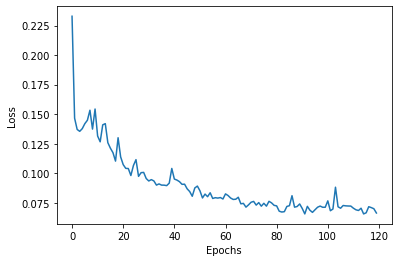

Get prediction data LOGI done.
Get options LOGI done.
Get options LOGI done.
Series([], Name: Earnings Date, dtype: float64)
Get calendar LOGI error.
Get news LOGI done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/LOGI.html
Get chart LOGI done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price LVS done.
Get prediction data LVS done.
Get options LVS done.
Get options LVS done.
0    2022-01-25 10:59:00
1    2022-01-31 12:00:00
Name: Earnings Date, dtype: object
Get calendar LVS done.
Get news LVS error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/LVS.html
Get chart LVS done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price MSFT done.
Get prediction data MSFT done.
Get options MSFT done.
Get options MSFT done.
0    2022-01-24 00:00:00
1    2022-01-28 00:00:00
Name: Earnings Date, dtype: object
Get calendar MSFT done.
Get news MSFT error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/MSFT.html
Get chart MSFT done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price MU done.
Get prediction data MU done.
Get options MU done.
Get options MU done.
0    2022-03-29 10:59:00
1    2022-04-04 12:00:00
Name: Earnings Date, dtype: object
Get calendar MU done.
Get news MU done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/MU.html
Get chart MU done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price NCLH done.
Get prediction data NCLH done.
Get options NCLH done.
Get options NCLH done.
0    2022-02-23 00:00:00
1    2022-02-28 00:00:00
Name: Earnings Date, dtype: object
Get calendar NCLH done.
Get news NCLH error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/NCLH.html
Get chart NCLH done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price NFLX done.
Get prediction data NFLX done.
Get options NFLX done.
Get options NFLX done.
Value    2022-01-20 00:00:00
Name: Earnings Date, dtype: object
Get calendar NFLX done.
Get news NFLX error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/NFLX.html
Get chart NFLX done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price NKE done.
Get prediction data NKE done.
Get options NKE done.
Get options NKE done.
0    2022-03-16 00:00:00
1    2022-03-21 00:00:00
Name: Earnings Date, dtype: object
Get calendar NKE done.
Get news NKE error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/NKE.html
Get chart NKE done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price NVDA done.
Get prediction data NVDA done.
Get options NVDA done.
Get options NVDA done.
0    2022-02-22 10:59:00
1    2022-02-28 12:00:00
Name: Earnings Date, dtype: object
Get calendar NVDA done.
Get news NVDA done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/NVDA.html
Get chart NVDA done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price PLTR done.
Get prediction data PLTR done.
Get options PLTR done.
Get options PLTR done.
0    2022-02-14 00:00:00
1    2022-02-18 00:00:00
Name: Earnings Date, dtype: object
Get calendar PLTR done.
Get news PLTR error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/PLTR.html
Get chart PLTR done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price PYPL done.
Get prediction data PYPL done.
Get options PYPL done.
Get options PYPL done.
0    2022-02-01 00:00:00
1    2022-02-07 00:00:00
Name: Earnings Date, dtype: object
Get calendar PYPL done.
Get news PYPL error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/PYPL.html
Get chart PYPL done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price QQQ done.
Get prediction data QQQ done.
Get options QQQ done.
Get options QQQ done.
Get news QQQ error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/QQQ.html
Get chart QQQ done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price RBLX done.
Get prediction data RBLX done.
Get options RBLX done.
Get options RBLX done.
Value    2021-11-08 00:00:00
Name: Earnings Date, dtype: object
Get calendar RBLX done.
Get news RBLX error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/RBLX.html
Get chart RBLX done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price RKLB done.
Get prediction data RKLB done.
Get options RKLB done.
Get options RKLB done.
Series([], Name: Earnings Date, dtype: float64)
Get calendar RKLB error.
Get news RKLB error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/RKLB.html
Get chart RKLB done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price SNAP done.
Get prediction data SNAP done.
Get options SNAP done.
Get options SNAP done.
0    2022-02-02 00:00:00
1    2022-02-07 00:00:00
Name: Earnings Date, dtype: object
Get calendar SNAP done.
Get news SNAP error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/SNAP.html
Get chart SNAP done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price SOFI done.
Get prediction data SOFI done.
Get options SOFI done.
Get options SOFI done.
Value    2021-11-10 00:00:00
Name: Earnings Date, dtype: object
Get calendar SOFI done.
Get news SOFI error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/SOFI.html
Get chart SOFI done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price SPY done.
Get prediction data SPY done.
Get options SPY done.
Get options SPY done.
Get news SPY error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/SPY.html
Get chart SPY done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price SQ done.
Get prediction data SQ done.
Get options SQ done.
Get options SQ done.
0    2022-02-21 00:00:00
1    2022-02-25 00:00:00
Name: Earnings Date, dtype: object
Get calendar SQ done.
Get news SQ done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/SQ.html
Get chart SQ done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price TSLA done.
Get prediction data TSLA done.
Get options TSLA done.
Get options TSLA done.
0    2022-01-25 21:00:00
1    2022-01-31 21:00:00
Name: Earnings Date, dtype: object
Get calendar TSLA done.
Get news TSLA done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/TSLA.html
Get chart TSLA done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price TWTR done.
Get prediction data TWTR done.
Get options TWTR done.
Get options TWTR done.
Value    2022-02-10 00:00:00
Name: Earnings Date, dtype: object
Get calendar TWTR done.
Get news TWTR error.
Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/TWTR.html
Get chart TWTR done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price U done.
Get prediction data U done.
Get options U done.
Get options U done.
0    2022-02-02 00:00:00
1    2022-02-07 00:00:00
Name: Earnings Date, dtype: object
Get calendar U done.
Get news U error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/U.html
Get chart U done.
[*********************100%***********************]  1 of 1 completed
Get Stock Price UBER done.
Get prediction data UBER done.
Get options UBER done.
Get options UBER done.
Value    2022-02-09 00:00:00
Name: Earnings Date, dtype: object
Get calendar UBER done.
Get news UBER error.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/drive/MyDrive/models/charts/2022-01-10/UBER.html
Get chart UBER done.
Errors: ['FFND']


In [48]:
symbols = ['ABBV','AFRM','AMD','AMZN','APPS','ASTR','ATVI','BNGO',
           'CAT','CCL','CHWY','COST','CRM',
           'DIA','DIS','DKNG','ETSY','FFND','HOG','HUT','IWM','JETS','LOGI',
           'LVS','MSFT','MU','NCLH','NFLX','NKE','NVDA','PLTR','PYPL','QQQ',
           'RBLX','RKLB','SNAP','SOFI','SPY','SQ','TSLA','TWTR','U','UBER']

symbols1 = ['AAPL','ARKG','ARKK','ARKQ',
           'BA','CHPT','COIN','DDOG',
           'DOCU','EA','FB','GOOGL']

symbols2 = ['MA','MP',
           'MRNA','MSTR','NNDM']

symbols3 = ['PFE','PINS',
           'ROKU','SBUX','SHOP','SOXL','SOXX']

symbols4 = ['TDOC','TEN','TGT','TLT','TTD','UAA',
           'V','VTI','WBA','VALE','WMT','WYNN','XLE','XLF','XLNX','ZM']

symbols5 = ['U','PENN','QCOM','LCID','AAL']
symbols6 = ['RIVN','HOOD']
save_charts(symbols,True)
#save_charts(symbols1,True)
#save_charts(symbols2,True)
#save_charts(symbols3,True)
#save_charts(symbols4,True)
#save_charts(symbols5,True)
#save_charts(symbols6,True)